Librairies

In [1]:
import pandas as pd
import fun_plot as plot
import ALS_RNAseq as als

import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV

from imblearn.over_sampling import SMOTE
from collections import Counter

from matplotlib import pyplot as plt

Var

In [2]:
path = "./Data" # the path of the data
path_test = "./Data_test"

In [3]:
seq : als.ALS_RNAseq = als.ALS_RNAseq(path, load_matrix="RNA_counts_matrix.csv")

original_shape_data_matrix: tuple[int, int] = seq.data.shape
original_shape_samples: tuple[int, int] = seq.samples.shape

# Sample Description

## Bar Charts for "Disease Groups" and Sample "Sources":

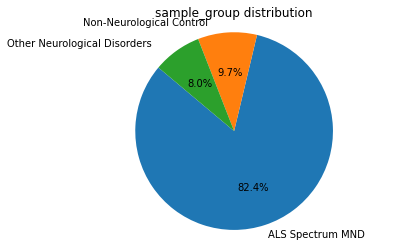

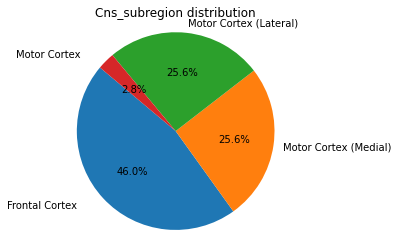

In [4]:
# Fonctionne mais barChart moins percurant que les camemberts

# plot.bar_chart(seq.sample_annotations['sample_group'].value_counts(), 'Disease Groups distribution', 'Disease Groups', 'Number of samples')
# plot.bar_chart(seq.sample_annotations['Cns_subregion'].value_counts(), 'CNS Subregions distribution', 'CNS Subregions', 'Number of samples')

plot.pie(seq.samples, 'sample_group')
plot.pie(seq.samples, 'Cns_subregion')

## Histograms for Measures of Central Tendency and Dispersion

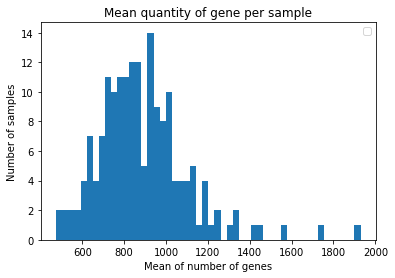

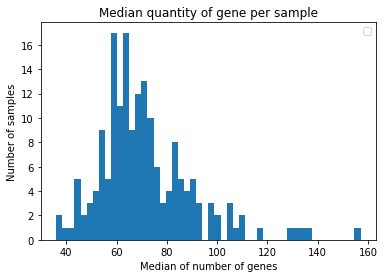

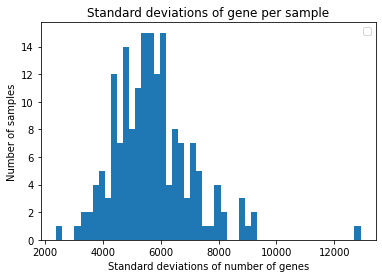

In [5]:
plot.hist(seq.get_stat(1, np.mean), 'Mean quantity of gene per sample', 'Mean of number of genes', 'Number of samples')
plot.hist(seq.get_stat(1, np.median), 'Median quantity of gene per sample', 'Median of number of genes', 'Number of samples')
plot.hist(seq.get_stat(1, np.std), 'Standard deviations of gene per sample', 'Standard deviations of number of genes', 'Number of samples')

## Summary Tables

### Analyze the table below:

We have 5 samples with a cns subregion == Motor Cortex with no precision if Medial or Lateral. These 5 samples were taken from people who have|had ALS. There is thus a high risk of overfit. To do this, we will delete these 5 samples.

**Other points to note** :

There are many samples taken from the same subject. This even goes sometimes to have 1 subject with 2 samples, the same day on the same area but with completely different genes.

<u>Hypothesis</u>: There are other subregions in the subregions that we have.

We admit that our hypothesis is correct. Thus, the samples are not wrong.
The only problem is that there are more duplicates in people with ALS. This creates an imbalance between the classes.

In [6]:
seq.get_nbr_of_samples_per_disease_group_and_source()

ALS Spectrum MND  \
Frontal Cortex                              65   
Motor Cortex (Medial)                       38   
Motor Cortex (Lateral)                      37   
Motor Cortex                                 5   

                              ALS Spectrum MND (distinct subject)  No ALS  \
Frontal Cortex                                                 63      16   
Motor Cortex (Medial)                                          37       7   
Motor Cortex (Lateral)                                         35       8   
Motor Cortex                                                    4       0   

                              No ALS (distinct subject)  
Frontal Cortex                                       15  
Motor Cortex (Medial)                                 7  
Motor Cortex (Lateral)                                8  
Motor Cortex                                          0

In [7]:
# Test if a subject_id is not in two different groups (ALS Spectrum MND, Other Neurological Disorders, Non-Neurological Control)

df = seq.samples
df_als = df[df["sample_group"] == "ALS Spectrum MND      "]
df_other = df[df["sample_group"] == "Other Neurological Disorders      "]
df_non = df[df["sample_group"] == "Non-Neurological Control      "]

nbr_sub_id_ALS = len(list(df_als["subject_id"].unique()))
nbr_sub_id_other = len(list(df_other["subject_id"].unique()))
nbr_sub_id_non = len(list(df_non["subject_id"].unique()))

nbr_total = len(list(df_als["subject_id"].unique()) + list(df_other["subject_id"].unique()) + list(df_non["subject_id"].unique()))

print(f"Test is good ? {nbr_sub_id_ALS + nbr_sub_id_other + nbr_sub_id_non == nbr_total}")

Test is good ? True


In [8]:
seq.get_stat_per_sample()

mean  median          std
GSM3533230  1041.382378    92.0  7144.825327
GSM3533231   881.608503    65.0  6556.671306
GSM3533232   802.592132    58.0  5618.597049
GSM3533233   785.868615    65.0  6617.622136
GSM3533234   906.813525    61.0  6815.012773
...                 ...     ...          ...
GSM3533401   621.179187    51.0  3875.865645
GSM3533402  1412.596518   136.0  7679.098861
GSM3533403  1142.241288   101.0  5264.614249
GSM3533404  1435.251546   132.0  7032.216325
GSM3533405   932.616240    92.0  6028.260557

[176 rows x 3 columns]

We remove Motor Cortex samples like say above.

In [9]:
def remove_outliers_group(sample_id_to_remove: list[str]):
    
    df_data_temp: pd.DataFrame = seq.data.copy()
    df_sample_temp: pd.DataFrame = seq.samples.copy()

    df_data_temp = df_data_temp[~df_data_temp.index.isin(sample_id_to_remove)]
    df_sample_temp = df_sample_temp[~df_sample_temp["Sample_id"].isin(sample_id_to_remove)]
    
    # we set
    seq.samples = df_sample_temp
    seq.data = df_data_temp

def remove_outliers_group_from_boxplot(ll: list[list[pd.Series]]):
    for l in ll:
        for df in l:
            q1 = np.percentile(df, 25)
            q3 = np.percentile(df, 75)
            IQR = q3 - q1
            
            outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

            remove_outliers_group(outliers.index.tolist())


In [10]:
print(f"Shape of sample_annotation before : {seq.samples.shape} and shape of datamatrix before : {seq.data.shape}")

group_to_remove: str = "Motor Cortex      "

sample_id_to_remove: list[str] = seq.samples[seq.samples["Cns_subregion"] == group_to_remove]["Sample_id"].tolist()

remove_outliers_group(sample_id_to_remove)

print(f"Shape of sample_annotation after : {seq.samples.shape} and shape of datamatrix before : {seq.data.shape}")

Shape of sample_annotation before : (176, 4) and shape of datamatrix before : (176, 28953)
Shape of sample_annotation after : (171, 4) and shape of datamatrix before : (171, 28953)


## Box Plots

As a reminder, the round on the boxplot means outliers.

In [11]:
seq.get_data_matrix_group_by('sample_group', ax=1)

[GSM3533230    1041.382378
 GSM3533231     881.608503
 GSM3533232     802.592132
 GSM3533233     785.868615
 GSM3533234     906.813525
                  ...     
 GSM3533401     621.179187
 GSM3533402    1412.596518
 GSM3533403    1142.241288
 GSM3533404    1435.251546
 GSM3533405     932.616240
 Length: 140, dtype: float64,
 GSM3533238     685.807826
 GSM3533251    1020.831416
 GSM3533259    1083.852589
 GSM3533266     927.259282
 GSM3533272    1191.266017
 GSM3533277     946.817912
 GSM3533282     942.161089
 GSM3533290     800.363382
 GSM3533366     858.160571
 GSM3533367    1190.239492
 GSM3533368     673.538286
 GSM3533381     506.155632
 GSM3533385     648.872483
 GSM3533387     630.496011
 GSM3533393     995.270956
 GSM3533394     929.008773
 GSM3533396     901.750527
 dtype: float64,
 GSM3533298     769.895693
 GSM3533299    1025.583117
 GSM3533300     811.718647
 GSM3533330    1075.577280
 GSM3533331     905.692329
 GSM3533332     872.489103
 GSM3533333     927.447173
 GSM3533

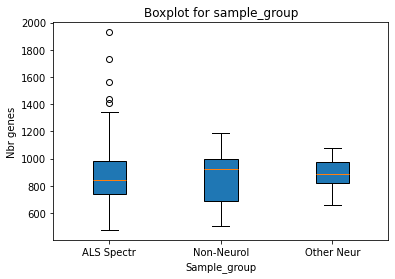

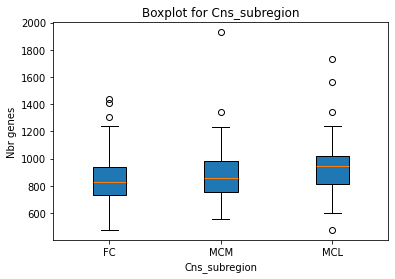

In [12]:
plot.boxplot(seq.get_data_matrix_group_by('sample_group', ax=1), 'Boxplot for sample_group', 'Sample_group', 'Nbr genes', list(seq.samples['sample_group'].unique()))

plot.boxplot(seq.get_data_matrix_group_by('Cns_subregion', ax=1), 'Boxplot for Cns_subregion', 'Cns_subregion', 'Nbr genes', list(seq.samples['Cns_subregion'].unique()))

#### Analyze the boxplot above:

This first approach is too naive. For example, for the first graph, we have 5 outliers. This could correspond to the 5 samples of an underrepresented subregion. Thus, the box plot would consider this as outliers.
Same thing for the second graph


#### Analyze the boxplot below:

It's better to comparate each subregion in each sample group. And comparate each sample group in each subregion.
Thus, we ll delete each samples who are considered as outliers in the boxplot below.

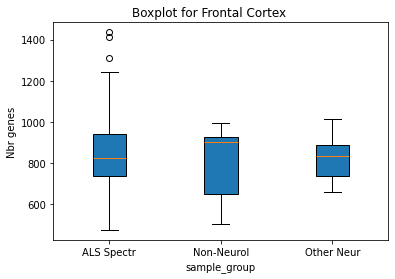

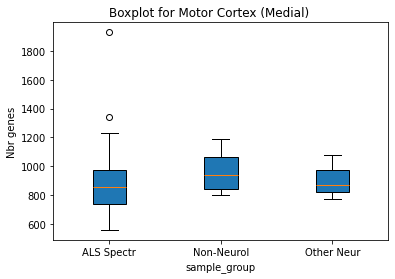

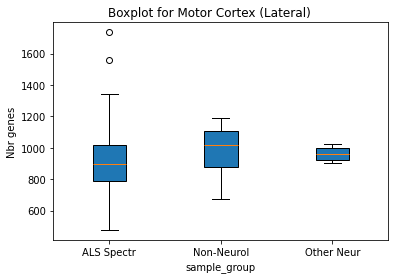

In [13]:
l_sample: list = []
l_subregion: list = list(seq.samples["Cns_subregion"].unique())

for subregion in seq.samples["Cns_subregion"].unique():
    l_sample.append(seq.samples[seq.samples["Cns_subregion"] == subregion])


ll: list = []
for i, df in enumerate (l_sample):
    l: list = []
    l_sample_group: list = df["sample_group"].unique()
    l_sample_group.sort()

    for ele in l_sample_group:
        gsm: np.ndarray = np.array(df[df["sample_group"] == ele]['Sample_id'])

        l.append(np.mean(seq.data[seq.data.index.isin(gsm)], axis=1))
    ll.append(l)
    plot.boxplot(l, f'Boxplot for {l_subregion[i]}', "sample_group", 'Nbr genes', l_sample_group)

We remove ALS outliers like say above.

In [14]:
print(f"Shape of sample_annotation before : {seq.samples.shape} and shape of datamatrix before : {seq.data.shape}")

remove_outliers_group_from_boxplot(ll)

print(f"Shape of sample_annotation after : {seq.samples.shape} and shape of datamatrix before : {seq.data.shape}")

Shape of sample_annotation before : (171, 4) and shape of datamatrix before : (171, 28953)
Shape of sample_annotation after : (164, 4) and shape of datamatrix before : (164, 28953)


## Heatmap

In [15]:
import math

df = seq.data.apply(lambda x: [math.log(int(ele) + 1) for ele in x])

plot.heatmap(df, 'Heatmap of the data matrix (log)', 'Genes', 'Samples')

# RNA Counts Description

## Gene Expression Overview

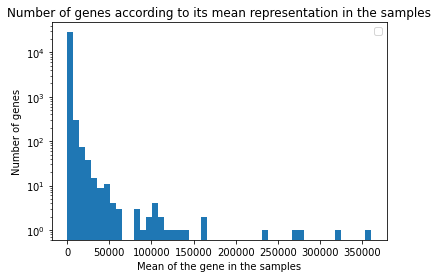

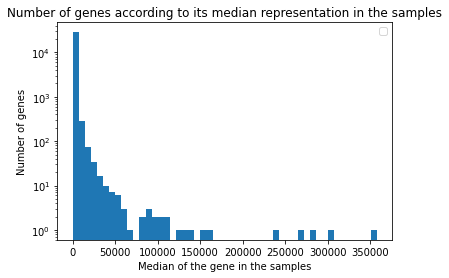

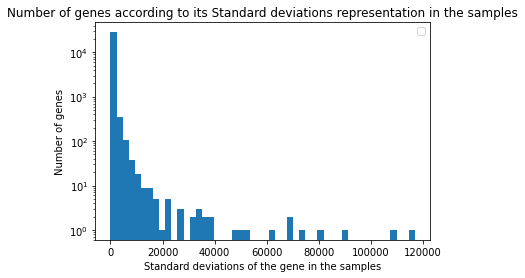

In [ ]:
plot.hist(seq.get_stat(0, np.mean), 'Number of genes according to its mean representation in the samples', 'Mean of the gene in the samples', 'Number of genes', withLog=True)
plot.hist(seq.get_stat(0, np.median), 'Number of genes according to its median representation in the samples', 'Median of the gene in the samples', 'Number of genes', withLog=True)
plot.hist(seq.get_stat(0, np.std), 'Number of genes according to its Standard deviations representation in the samples', 'Standard deviations of the gene in the samples', 'Number of genes', withLog=True)

## Box plots

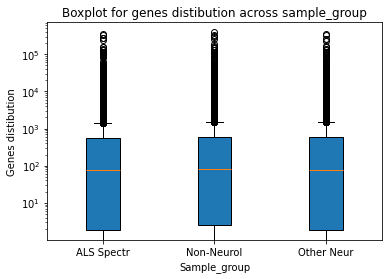

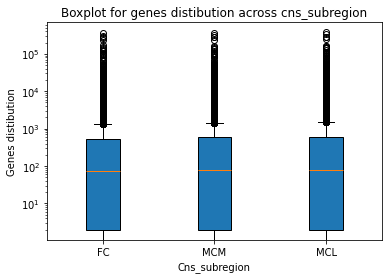

In [ ]:
plot.boxplot(seq.get_stat_group_by('sample_group', ax=0), 'Boxplot for genes distibution across sample_group', 'Sample_group', 'Genes distibution', list(seq.samples['sample_group'].unique()), withLog=True)

plot.boxplot(seq.get_stat_group_by('Cns_subregion', ax=0), 'Boxplot for genes distibution across cns_subregion', 'Cns_subregion', 'Genes distibution', list(seq.samples['Cns_subregion'].unique()), withLog=True)

There are some genes outliers in the boxplot. We will remove them.

In [ ]:
l = seq.get_stat_group_by('sample_group', ax=0)

genes_outlier_sample_group: set = set()

for df in l:
    q1 = np.percentile(df, 25)
    q3 = np.percentile(df, 75)
    IQR = q3 - q1
    
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    temp = outliers.index.tolist()
    genes_outlier_sample_group |= set(temp)

print(f"There are {len(genes_outlier_sample_group)} genes that are outliers in at least one group")

There are 3841 genes that are outliers in at least one group


In [ ]:
l = seq.get_stat_group_by('Cns_subregion', ax=0)

genes_outlier_subregion: set = set()

for df in l:
    q1 = np.percentile(df, 25)
    q3 = np.percentile(df, 75)
    IQR = q3 - q1
    
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    temp = outliers.index.tolist()
    genes_outlier_subregion |= set(temp)

print(f"There are {len(genes_outlier_subregion)} genes that are outliers in at least one subregion")

There are 3788 genes that are outliers in at least one subregion


In [ ]:
all_genes_outlier = genes_outlier_subregion | genes_outlier_sample_group
print(f"There are {len(all_genes_outlier)} genes that are outliers")

There are 3888 genes that are outliers


In [ ]:
df_data_temp: pd.DataFrame = seq.data.copy()

try:
    df_data_temp.drop(list(all_genes_outlier), axis=1, inplace=True)
except KeyError:
    print("Already removed")

# we set
seq.data = df_data_temp

print(f"Shape of datamatrix now : {seq.data.shape}")

Shape of datamatrix now : (164, 25065)


## Histograms

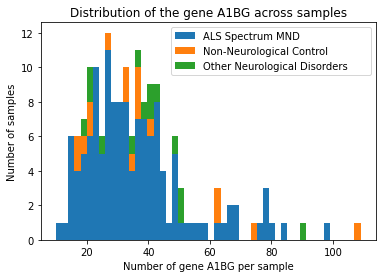

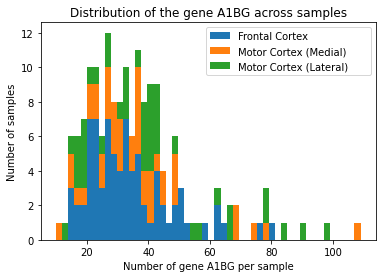

In [ ]:
def displayHistoForSelectedGene(list_df: list[pd.DataFrame], selectedGene: str, legend: list[str] = [], withLog: bool = False) -> None:
    l = []
    for df in list_df:
        l.append(df[selectedGene])

    plot.hist(l, f'Distribution of the gene {selectedGene} across samples', f'Number of gene {selectedGene} per sample', 'Number of samples', legend=legend, withLog=withLog)

displayHistoForSelectedGene(seq.get_stat_group_by('sample_group'), seq.data.columns[0], legend = list(seq.samples['sample_group'].unique()))
displayHistoForSelectedGene(seq.get_stat_group_by('Cns_subregion'), seq.data.columns[0], legend = list(seq.samples['Cns_subregion'].unique()))

## Heatmaps

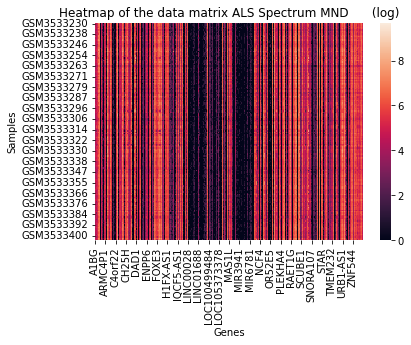

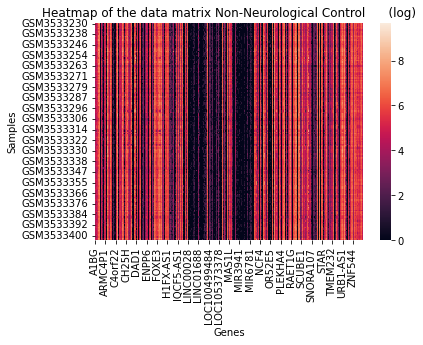

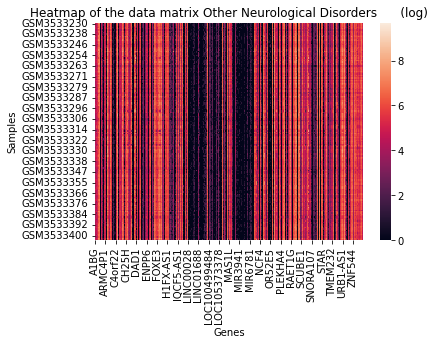

In [ ]:
for i, df in enumerate (seq.get_stat_group_by('sample_group')):
    temp = seq.data.apply(lambda x: [math.log(int(ele) + 1) for ele in x])
    s = 'Heatmap of the data matrix ' + list(seq.samples['sample_group'].unique())[i] + '(log)'
    plot.heatmap(temp, s, 'Genes', 'Samples') 


## Step 2 - Conclusion

Let's look at how many samples we have left after removing the outliers.

In [ ]:
print(f"Shape of datamatrix : before {original_shape_data_matrix}\t|\t now {seq.data.shape}")
print(f"Shape of sample_annotation : before {original_shape_samples}\t|\t now {seq.samples.shape}")


Shape of datamatrix : before (176, 28953)	|	 now (164, 25065)
Shape of sample_annotation : before (176, 4)	|	 now (164, 4)


# Step3 - PCA

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(seq.data) # my_data being your dataframe containing your genes in column and samples in row

n_components: int = 4
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(X)

df = pd.DataFrame(principalComponents)
df.index = seq.data.index

In [ ]:
def getGroupBy(df: pd.DataFrame, group_by: str) -> list[pd.DataFrame]:
    l : list = []

    for ele in seq.samples[group_by].unique():
        gsm = np.array(seq.samples[seq.samples[group_by] == ele]['Sample_id'])
        l.append((df[seq.data.index.isin(gsm)]))
    return l

In [ ]:
pca.explained_variance_ratio_

array([0.21236939, 0.0935917 , 0.08026329, 0.04959251])

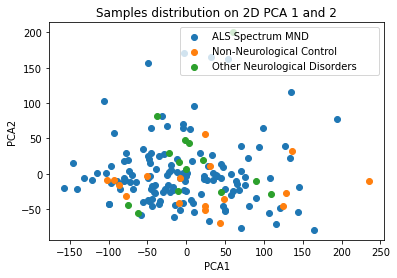

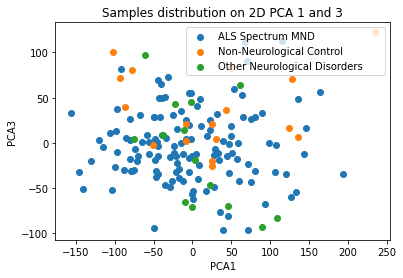

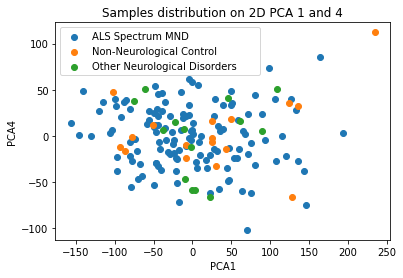

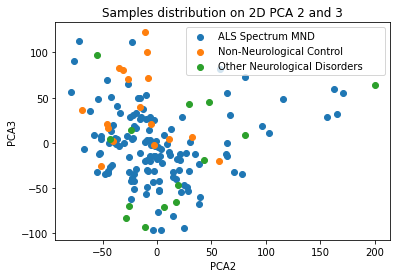

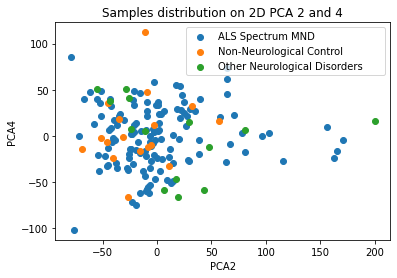

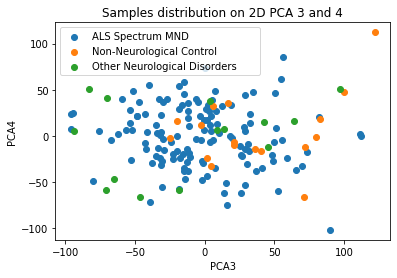

In [ ]:
import itertools

# get all permutation of a list de taille 2
for i, j in itertools.combinations(range(n_components), 2):
    plot.scatter(getGroupBy(df[[i, j]], "sample_group"), f"Samples distribution on 2D PCA {i+1} and {j+1}", f"PCA{i+1}", f"PCA{j+1}", [i, j], list(seq.samples['sample_group'].unique()))

# Step 4 (optional) - UMAP

# Step 5 - Univariate Analysis

Pour chaque gene on a une p-value et un fold change (donc chaque point du volcano plot est un gène)

<!-- 
#### p-values

p-value = signification statistique. C'est le fait qu'un gène est plus exp

p-value : probabilité d'obtenir le bon résultat grâce au hasard (proche de 1 = pas bon)

Corriger les p-values pour les faux positifs (FDR) -> Benjamini-Hochberg (BH) -> 0.05 (seuil) -> 5% de faux positifs (seuil)

Cut off : p-values ajustées > à 0.05

'+ on a de pts, + la p-value est faible (logique)

#### Fold Change

fold change : signification biologique (compare gène entre eux) = expression du gène X in class 1 / expression du gène X in class 2

2 en fold change -> ça veut dire que c'est le double
Mettre en Log 2. Donc 3 en log 2 c'est que c'est 2^3 = 8 fois plus (grand ou petit (dépend))


fold change important car si p-value est faible mais fold change est faible alors c'est pas intéressant (car les pts sont trop proches)

cut off de fold change (2) -> si fold change est inférieur à 2 alors on ne le prend pas en compte




https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_minimal_pydeseq2_pipeline.html#sphx-glr-auto-examples-plot-minimal-pydeseq2-pipeline-py

LFC -> permet de calculer la grandeur


#### Statistical analysis with the DeseqStats classé

garder uniquement les gènes avec les> p_values < 0.05


#### Multifactor analysis

Si biais (genre sexe) -> on peut le corriger avec


LFC shrinkage (multifactor) -> permet de réduire le bruit :
    base mean ballec, 
    
 -->

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [ ]:
metadata_aligned2 = seq.samples.copy()
metadata_aligned2.index = seq.data.index
metadata_aligned2 = metadata_aligned2[["Cns_subregion", "sample_group"]]

In [ ]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=seq.data,
    metadata=metadata_aligned2,
    design_factors="sample_group",
    refit_cooks=True,
    inference=inference,
)

C:\Users\User\AppData\Local\Temp\ipykernel_14532\239790250.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(


In [ ]:
# Compute normalization factors
dds.fit_size_factors()


# Fit log fold changes
print("Fitting log fold changes\n\n")

dds.fit_LFC()

# Calculate Cooks distances and refit
print("Calculating Cooks distances and refitting\n\n")

dds.calculate_cooks()
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()

# Statistical analysis with the DeseqStats
stat_res = DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True)


# Wald tests
print("Running Wald tests\n\n")
stat_res.run_wald_test()
stat_res.p_values


# P-value adjustment
print("Running p-value adjustment\n\n")
if stat_res.independent_filter:
    stat_res._independent_filtering()
else:
    stat_res._p_value_adjustment()

Fitting size factors...
... done in 0.33 seconds.



Fitting log fold changes




Fitting dispersions...
... done in 13.94 seconds.

Fitting dispersion trend curve...
... done in 0.94 seconds.

Fitting MAP dispersions...
... done in 19.65 seconds.

Fitting LFCs...
... done in 8.91 seconds.



Calculating Cooks distances and refitting




Replacing 215 outlier genes.

Fitting dispersions...
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 0.28 seconds.

Fitting LFCs...
... done in 0.23 seconds.

Running Wald tests...


Running Wald tests




... done in 3.87 seconds.



Running p-value adjustment




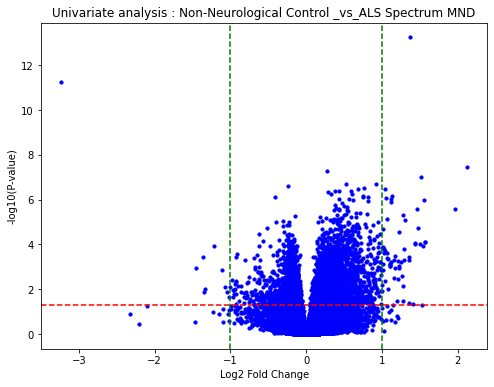

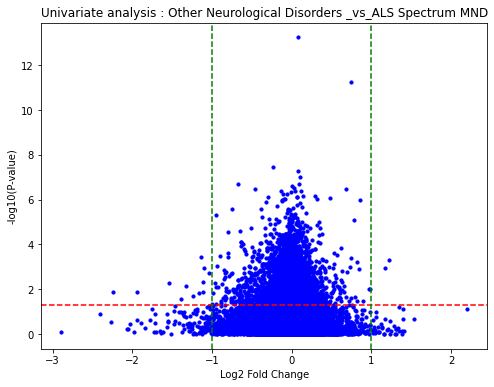

In [ ]:
pvalues = stat_res.p_values
fold_changes = stat_res.LFC

plot.volcano_plot(fold_changes[fold_changes.columns[1]], pvalues, 'Univariate analysis : Non-Neurological Control _vs_ALS Spectrum MND') # type: ignore
plot.volcano_plot(fold_changes[fold_changes.columns[2]], pvalues, 'Univariate analysis : Other Neurological Disorders _vs_ALS Spectrum MND') # type: ignore

Voici les 100 gènes les plus significatifs (les plus différentiels) :

In [ ]:
df_p_values = pd.DataFrame(list(pvalues.items()), columns=['Gene', 'P_Value'])
df_fold_changes = pd.DataFrame(np.array([list(fold_changes.index), list(fold_changes[fold_changes.columns[1]]), list(fold_changes[fold_changes.columns[2]])]).T, columns=['Gene', 'Fold_Change 1 vs 2', 'Fold_Change 1 vs 3'])

df_combined = pd.merge(df_p_values, df_fold_changes, on='Gene')

# cut off
p_value_cutoff = -np.log10(0.05)
lfc_cutoff = 1.0

# str -> float
df_combined[df_combined.columns[1]] = df_combined[df_combined.columns[1]].apply(lambda x: float(x))
df_combined[df_combined.columns[2]] = df_combined[df_combined.columns[2]].apply(lambda x: float(x))
df_combined[df_combined.columns[3]] = df_combined[df_combined.columns[3]].apply(lambda x: float(x))

df_combined = df_combined.sort_values(by="P_Value", ascending=True) 

# keep only significant genes
significant_genes_univariate = df_combined[
                                (df_combined['P_Value'] < p_value_cutoff) 
                                & (
                                    (abs(df_combined[df_combined.columns[2]]) > lfc_cutoff) 
                                    | (abs(df_combined[df_combined.columns[3]]) > lfc_cutoff)
                                )]


print(f"We have {significant_genes_univariate.shape[0]} significant genes")

We have 255 significant genes


# Step 6 & 7 : Faire Soit la 6 soit la 7

In [ ]:
# Train data
X_raw = seq.data

label_encoder = LabelEncoder()
y_train = np.array(label_encoder.fit_transform(np.array(seq.samples['sample_group'])))


# Test data
seq_test: als.ALS_RNAseq = als.ALS_RNAseq(path_test, "RNA_counts_matrix_test.csv" , is_test_data=True)

X_test_raw = seq_test.data
y_test_raw = np.array(label_encoder.transform(np.array(seq_test.samples['sample_group'])))

# we keep only the genes that are in the training set and the test set + when sum of the gene is > 0
genes_to_keep_train = X_raw.columns[X_raw.sum(axis=0) > 0]
genes_to_keep_test = X_test_raw.columns[X_test_raw.sum(axis=0) > 0]
genes_to_keep_all = genes_to_keep_train.intersection(genes_to_keep_test)

genes_inter = X_raw.columns.intersection(X_test_raw.columns)

columns_inter = genes_inter.intersection(genes_to_keep_all)

X_raw = X_raw[columns_inter]
X_test_raw = X_test_raw[columns_inter]

In [ ]:
# normalization
scalerStep6 = StandardScaler()
X_raw_scaler = scalerStep6.fit_transform(X_raw)

scalerStep6_test = StandardScaler()
X_test_raw_scaler = scalerStep6_test.fit_transform(X_test_raw)

# pca
n_components: int | float = 150 # Determined after test with several values
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(X_raw_scaler)
x_test_pca = pca.transform(X_test_raw_scaler)

# x_train_pca = X_raw_scaler
# x_test_pca = X_test_raw_scaler


We add features for subregion (one hot vector)

In [ ]:
# # train data
# column_to_transform_train: pd.Series = seq.samples["Cns_subregion"]

# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(column_to_transform_train.to_numpy().reshape(-1, 1))

# x_train_pca_onehot = np.concatenate((x_train_pca, enc.transform(column_to_transform_train.to_numpy().reshape(-1, 1)).toarray()), axis=1)

# # test data
# column_to_transform_test: pd.Series = seq_test.samples["Cns_subregion"]

# x_test_pca_onehot = np.concatenate((x_test_pca, enc.transform(column_to_transform_test.to_numpy().reshape(-1, 1)).toarray()), axis=1)

We oversample the non-ALS samples and other disease to balance the classes.

In [ ]:
print('Avant rééchantillonnage:', Counter(y_train))

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_train_pca, y_train) # type: ignore

print('Après rééchantillonnage:', Counter(y_resampled))

Avant rééchantillonnage: Counter({0: 133, 1: 17, 2: 14})
Après rééchantillonnage: Counter({0: 133, 1: 133, 2: 133})


In [ ]:
X_train = X_resampled
y_train = y_resampled

X_test = x_test_pca
y_test = y_test_raw

In [ ]:
from sklearn.metrics import f1_score

def custom_f1_score(log_reg, X_test, y_test, sample_weight=None):
    return f1_score(y_test, log_reg.predict(X_test), average='micro', sample_weight=sample_weight)

In [ ]:
elasticNet = LogisticRegressionCV(penalty='elasticnet', cv= 5, max_iter=5000, solver='saga', l1_ratios=[0.25,0.5,0.75], Cs=[0.1,0.5], scoring=custom_f1_score, n_jobs=-1)
elasticNet.fit(X_train, y_train) 

LogisticRegressionCV(Cs=[0.1, 0.5], cv=5, l1_ratios=[0.25, 0.5, 0.75],
                     max_iter=5000, n_jobs=-1, penalty='elasticnet',
                     scoring=<function custom_f1_score at 0x00000265F528EC20>,
                     solver='saga')

In [ ]:
print(label_encoder.classes_)

plot.display_metrics_and_confusion_matrix(elasticNet, X_test, y_test)

['ALS Spectrum MND      ' 'Non-Neurological Control      '
 'Other Neurological Disorders      ']
Mean accuracy : 0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.82      0.73        22
           1       0.80      0.33      0.47        12
           2       0.33      0.50      0.40         4

    accuracy                           0.63        38
   macro avg       0.60      0.55      0.54        38
weighted avg       0.67      0.63      0.62        38



#### Try to find biomarkers

we get the coefficients of the model to see which features are the most important

In [ ]:
def create_significant_genes_for_a_model(coefficients : np.ndarray, pca: PCA, columns_inter: pd.Index) -> pd.DataFrame:

    # dict to store the best genes for each new features according PCA
    column_names = list(columns_inter) 

    principal_components = pca.components_

    component_contributions = {}
    for i, component in enumerate(principal_components):
        component_name = f"Component_{i+1}"
        contributions = {column_names[j]: component[j] for j in range(len(column_names))}
        component_contributions[component_name] = contributions


    best_features_for_pca: dict = {}
    cpt: int = 0
    for component, contributions in component_contributions.items():
        sorted_contributions = sorted(contributions.items(), key=lambda x: abs(x[1]), reverse=True)

        best_features_for_pca[cpt] = sorted_contributions
        cpt += 1


    # dict to store the best features according ElasticNet
    df_coefficients: pd.DataFrame = pd.DataFrame(coefficients)

    for column in df_coefficients.columns:
        df_coefficients[column] = df_coefficients[column].apply(lambda value: abs(value))

    best_features_for_model = df_coefficients.sum(axis=0)
    best_features_for_model.sort_values(ascending=False, inplace=True)


    # df to store the best genes
    best_genes: dict = {}
    for feature in best_features_for_model.index:
        feature_value = best_features_for_model[feature]
        try: # when we added other features like onehot encoding
            for gene in best_features_for_pca[feature]:
                best_genes[gene[0]] = best_genes.get(gene[0], 0) + (feature_value * abs(gene[1]))
        except:
            pass

    df = pd.DataFrame({
        "Gene": list(best_genes.keys()),
        "Score": best_genes.values()}
                      )
    df.sort_values(by="Score", ascending=False, inplace=True)

    return df

In [ ]:
significant_genes_elasticNet = create_significant_genes_for_a_model(elasticNet.coef_, pca, columns_inter)

# STEP 7 - XGBOOST (Option 2)

The results are very bad. It always predicts the same class (ALS). I couldn't find a solution (variation of hyper-parameter, addition of weighting...). Thus, we will not take the results into account.

In [ ]:
from xgboost import XGBClassifier


model = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', n_jobs=-1, num_parallel_tree=10, n_estimators=1000, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=0.1, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, random_state=42, verbosity=1, use_label_encoder=False, tree_method='hist')
model.fit(X_train, y_train) 

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [00:25:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_class=3, num_parallel_tree=10, ...)

In [ ]:
print(label_encoder.classes_)

plot.display_metrics_and_confusion_matrix(model, X_test, y_test)

['ALS Spectrum MND      ' 'Non-Neurological Control      '
 'Other Neurological Disorders      ']
Mean accuracy : 0.5526315789473685
              precision    recall  f1-score   support

           0       0.57      0.95      0.71        22
           1       0.00      0.00      0.00        12
           2       1.00      0.00      0.00         4

    accuracy                           0.55        38
   macro avg       0.52      0.32      0.24        38
weighted avg       0.43      0.55      0.41        38



In [ ]:
# from xgboost import plot_importance
# plot_importance(model)

In [ ]:
# xgboost from sklearn
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# model = GradientBoostingClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, subsample=0.8, random_state=42)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
print(label_encoder.classes_)

plot.display_metrics_and_confusion_matrix(model, X_test, y_test)

['ALS Spectrum MND      ' 'Non-Neurological Control      '
 'Other Neurological Disorders      ']
Mean accuracy : 0.5263157894736842
              precision    recall  f1-score   support

           0       0.56      0.91      0.69        22
           1       0.00      0.00      0.00        12
           2       1.00      0.00      0.00         4

    accuracy                           0.53        38
   macro avg       0.52      0.30      0.23        38
weighted avg       0.43      0.53      0.40        38



# Step 8 -  Report your results

## How to build our TOP 100 genes ?

significant_genes_univariate has 255 genes ordered by importance.
significant_genes_elasticNet has 23139 genes ordered by importance.

### First selection

We select genes who are into significant_genes_univariate and the top 500 of significant_genes_elasticNet

### Second selection

We add genes who are into top 100 of significant_genes_univariate and the top 1000 of significant_genes_elasticNet

### Last selection

We complete our top 100 with the best genes according to significant_genes_elasticNet who aren t already selected.

### Recap

| Selection | New | Sum
| --- | --- | --- |
| First | 39 | 39 |
| Second | 5 | 44 |
| Last | 56 | 100 |



In [ ]:
significant_genes_elasticNet_top_100: list[str] = significant_genes_elasticNet["Gene"][:100].tolist()
significant_genes_elasticNet_top_500: list[str] = significant_genes_elasticNet["Gene"][:500].tolist()
significant_genes_elasticNet_top_1000: list[str] = significant_genes_elasticNet["Gene"][:1000].tolist()

In [ ]:
significant_genes_univariate_all: list[str] = significant_genes_univariate["Gene"].tolist()
significant_genes_univariate_top_100: list[str] = significant_genes_univariate["Gene"][:100].tolist()

In [ ]:
first_selection = set(significant_genes_univariate_all).intersection(set(significant_genes_elasticNet_top_500))
second_selection = set(significant_genes_univariate_top_100).intersection(set(significant_genes_elasticNet_top_1000))

first_and_second_selection: set = first_selection.union(second_selection)

In [ ]:
top100_not_already_selected = [gene for gene in significant_genes_elasticNet_top_100 if gene not in first_and_second_selection]

last_selection = top100_not_already_selected[:100 - len(first_and_second_selection)]

significant_genes_final: set = first_and_second_selection.union(set(last_selection))

In [ ]:
print(f"Here's the {len(significant_genes_final)} final significant genes")
print(" -" * 20)
print(significant_genes_final)

Here's the 100 final significant genes
 - - - - - - - - - - - - - - - - - - - -
{'LINC00433', 'LOC101927357', 'LINC02228', 'LINC01189', 'LOC105371267', 'KCNAB1-AS2', 'HLA-DRB5', 'OR2A12', 'CLMAT3', 'DBET', 'OR10J3', 'MRGPRG-AS1', 'MUC4', 'CXCL11', 'ELF3', 'LINC01163', 'OR10A6', 'TDRD15', 'UGT2A1', 'CT45A6', 'SLC35G6', 'IGLL5', 'CSN1S1', 'MST1L', 'MCCD1', 'MIR302E', 'CCL8', 'MIR4303', 'SNAR-F', 'BCORP1', 'LINC00417', 'ZNF722P', 'LOC100288162', 'GPX2', 'CYP4B1', 'TNXA', 'LINC00996', 'SIGLEC12', 'EXOC3L4', 'PRB4', 'GUCY1B2', 'MS4A1', 'MGC32805', 'FAM225B', 'DNASE1L3', 'ETV4', 'CATSPERD', 'SPRR2C', 'POTEF', 'OR10V2P', 'LOC101927827', 'LINC01502', 'KRT16', 'GZMA', 'MAPK8IP1P2', 'RTP2', 'LINC00687', 'LINC01148', 'ZNF385D-AS1', 'FGA', 'MYH11', 'LOC100129138', 'LINC02262', 'LINC00671', 'TGM7', 'NCRUPAR', 'DSC3', 'SH2D3A', 'LINC01214', 'FAM90A7P', 'LINC02506', 'ANKRD20A9P', 'C1orf100', 'PRG2', 'IL1B', 'P2RX2', 'MIR193B', 'KCNK16', 'GPR174', 'TTTY22', 'NUP210L', 'LOC283214', 'MSMB', 'ARL14EPL', 